In [2]:
reset -fs

In [3]:
import gzip
import itertools
import string
import wordcloud
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pylab as pl
import time
from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

---
# Part I EDA and Preprocessing
---
### `Download and Unzip Reviews into Pandas DataFrame`

In [4]:
import sqlite3
import pandas as pd

cnx = sqlite3.connect('/home/varuni/Documents/ML-LabProj/amazon-fine-food-reviews/database.sqlite')

review = pd.read_sql_query("SELECT * FROM Reviews", cnx)

* Convert compressed file of data into Pandas DataFrame

In [5]:
print(type(review))

<class 'pandas.core.frame.DataFrame'>


In [6]:
print('Dataset size: {:,} words'.format(len(review)))

Dataset size: 568,454 words


In [7]:
review[:3]
print(list(review))

['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


* **Reformat** $\underline{datetime}$ from raw form.

In [8]:
helpful =[]
for i in range(len(review)):
    helpful.append([review.loc[i,'HelpfulnessNumerator'],review.loc[i,'HelpfulnessDenominator']])
se = pd.Series(helpful)
review['helpful'] = se.values


print(helpful[:3])



[[1, 1], [0, 0], [1, 1]]


In [9]:
smt = []
for i in range (len(review)):
    if(review['Score'][i] > 2.5):
        smt.append(1) 
    else:
        smt.append(0)
senti = pd.Series(smt)
review['pos_neg'] = senti.values
count = Counter(smt)
print(count)
review = review[['ProductId','Summary','Text','Score', 'UserId', 'ProfileName','helpful','Time','pos_neg']]


Counter({1: 486417, 0: 82037})


* **Rearrange** the left-to-right by relevance

In [10]:
review.head(3)


,ProductId,Summary,Text,Score,UserId,ProfileName,helpful,Time,pos_neg
0,B001E4KFG0,Good Quality Dog Food,I have bought several of the Vitality canned d...,5,A3SGXH7AUHU8GW,delmartian,"[1, 1]",1303862400,1
1,B00813GRG4,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1,A1D87F6ZCVE5NK,dll pa,"[0, 0]",1346976000,0
2,B000LQOCH0,"""Delight"" says it all",This is a confection that has been around a fe...,4,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""","[1, 1]",1219017600,1


In [11]:
review.tail(3)

,ProductId,Summary,Text,Score,UserId,ProfileName,helpful,Time,pos_neg
568451,B004I613EE,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",5,A121AA1GQV751Z,"pksd ""pk_007""","[2, 2]",1329782400,1
568452,B004I613EE,Favorite Training and reward treat,These are the BEST treats for training and rew...,5,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""","[1, 1]",1331596800,1
568453,B001LR2CU2,Great Honey,"I am very satisfied ,product is as advertised,...",5,A3LGQPJCZVL9UC,srfell17,"[0, 0]",1338422400,1



## Number of Reviews by Unique Products [`ProductID`]


In [12]:
products = review['Score'].groupby(review['ProductId']).count()
print("Number of Unique Products in the Sports & Outdoors Category = {}".format(products.count()))
setprod = products.count()

Number of Unique Products in the Sports & Outdoors Category = 74258


**Top 20 Reviewed Products**

In [13]:
sorted_products = products.sort_values(ascending=False)

print("Top 20 Reviewed Products:\n")
print(sorted_products[:20], end='\n\n')
print('Most Reviewed Product, B007JFMH8M - has {} reviews.'.format(products.max()))

Top 20 Reviewed Products:

ProductId
B007JFMH8M    913
B002QWP89S    632
B002QWP8H0    632
B0026RQTGE    632
B002QWHJOU    632
B003B3OOPA    623
B001EO5Q64    567
B0013NUGDE    564
B007M83302    564
B007M832YY    564
B000VK8AVK    564
B0026KPDG8    564
B0026KNQSA    564
B001RVFERK    564
B001RVFEP2    564
B006HYLW32    564
B000KV7ZGQ    556
B000KV61FC    556
B005K4Q4LK    542
B000UBD88A    542
Name: Score, dtype: int64

Most Reviewed Product, B007JFMH8M - has 913 reviews.


**Bottom 20 Reviewed Products**

In [14]:
print("Bottom 20 Reviewed Products:\n")
print(sorted_products[setprod-20:], end='\n\n')
print('Least Reviewed Product (Sorted), B0042VELV2- has {} reviews.'.format(products.min()))

Bottom 20 Reviewed Products:

ProductId
B0042VELV2    1
B0042UA47I    1
B0042U90LO    1
B0042U5W8E    1
B0042TFZPA    1
B00132SVIM    1
B0042TFKSC    1
B0012ZBKAQ    1
B0012ZHEZQ    1
B0042TA97Y    1
B0042RQ2WM    1
B0012ZKQ1K    1
B0042RPDJK    1
B0012ZS77A    1
B0042RO4JK    1
B0012ZTVKM    1
B0042RMG3Q    1
B001326V4S    1
B0042RKTG2    1
B009WVB40S    1
Name: Score, dtype: int64

Least Reviewed Product (Sorted), B0042VELV2- has 1 reviews.


In [15]:
products.mode()

0    1
dtype: int64

---
## Preprocessing:
### `Remove punctuations, stopwords, and lemmatize`

In [16]:
review['Text'][:11]

0     I have bought several of the Vitality canned d...
1     Product arrived labeled as Jumbo Salted Peanut...
2     This is a confection that has been around a fe...
3     If you are looking for the secret ingredient i...
4     Great taffy at a great price.  There was a wid...
5     I got a wild hair for taffy and ordered this f...
6     This saltwater taffy had great flavors and was...
7     This taffy is so good.  It is very soft and ch...
8     Right now I'm mostly just sprouting this so my...
9     This is a very healthy dog food. Good for thei...
10    I don't know if it's the cactus or the tequila...
Name: Text, dtype: object

In [17]:
reviews = review['Text']

In [18]:
reviews.count()

568454

In [19]:
stops = stopwords.words('english')

In [20]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens


def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma


In [21]:
reviews = reviews.apply(lambda x: tokenize(x))

In [22]:
reviews[:11]
pickle.dump(review,open('tokens.pkl','wb'))


0     [I, have, bought, several, of, the, Vitality, ...
1     [Product, arrived, labeled, a, Jumbo, Salted, ...
2     [This, is, a, confection, that, ha, been, arou...
3     [If, you, are, looking, for, the, secret, ingr...
4     [Great, taffy, at, a, great, price, , There, w...
5     [I, got, a, wild, hair, for, taffy, and, order...
6     [This, saltwater, taffy, had, great, flavor, a...
7     [This, taffy, is, so, good, , It, is, very, so...
8     [Right, now, I, m, mostly, just, sprouting, th...
9     [This, is, a, very, healthy, dog, food, , Good...
10    [I, do, nt, know, if, it, s, the, cactus, or, ...
Name: Text, dtype: object

---
# Part II Modeling
---
## Model data

> **[ 1 ]** Classification / Sentiment Analysis ( Logistic Regression, MultinomialNB )

> **[ 2 ]** Clustering / Topic Modeling ( NMF and Lda )

# `Classification / Sentiment Analysis (LogReg, Mulitnomial)`

In [23]:
cloud = wordcloud.WordCloud(background_color='gray', max_font_size=60, 
                                relative_scaling=1).generate(' '.join(review.reviewText))

AttributeError: 'DataFrame' object has no attribute 'reviewText'

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud);

In [ ]:
review[:3]

### Insert `pos_neg` column for Sentiment modeling

         Negative reviews:      1-3 Stars  = 0
         Positive reviews:      4-5 Stars  = 1

 

In [ ]:
#review['pos_neg'] = [1 if x > 3 else 0 for x in review.overall]

In [24]:
review.head(3)

,ProductId,Summary,Text,Score,UserId,ProfileName,helpful,Time,pos_neg
0,B001E4KFG0,Good Quality Dog Food,I have bought several of the Vitality canned d...,5,A3SGXH7AUHU8GW,delmartian,"[1, 1]",1303862400,1
1,B00813GRG4,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1,A1D87F6ZCVE5NK,dll pa,"[0, 0]",1346976000,0
2,B000LQOCH0,"""Delight"" says it all",This is a confection that has been around a fe...,4,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""","[1, 1]",1219017600,1


In [25]:
review_text =review["Text"]

### Train/Test Split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(review.Text, review.pos_neg, random_state=0)

In [27]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (426340,)
y_train shape: (426340,)

x_test shape: (142114,)
y_test shape: (142114,)



---
# `Logistic Regression`

## `CountVectorizer`

In [28]:
# Vectorize X_train
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<426340x36651 sparse matrix of type '<class 'numpy.int64'>'
	with 22909919 stored elements in Compressed Sparse Row format>


In [29]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 36651


---
## Logistic Regression 
### on Training data

In [30]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

In [31]:
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.927


In [32]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

log_y_pred = logreg.predict(X_test)

In [33]:
logreg_score = accuracy_score(y_test, log_y_pred)
print("Accuracy:   {:.3f}".format(logreg_score))

Accuracy:   0.925


In [34]:
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test))) 

Training set score: 0.933
Test set score: 0.925


In [35]:
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 12838   7758]
 [  2885 118633]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


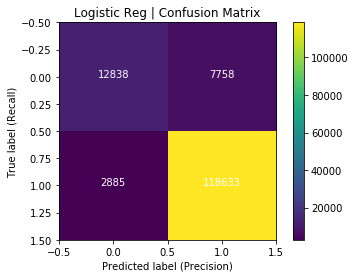

In [36]:
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar();

In [37]:
log_f1 = f1_score(y_test, log_y_pred)
print("Logistic Reg - F1 score: {:.3f}".format(log_f1))

Logistic Reg - F1 score: 0.957


---
## Multinomial Bayes 
### on Training data

## `CountVectorizer`

In [39]:
mnb = MultinomialNB(alpha=.01)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [40]:
mnb_y_pred = mnb.predict(X_test)

In [41]:
mnb_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score))

Accuracy:   0.900


In [42]:
print("Training set score: {:.3f}".format(mnb.score(X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(X_test, y_test)))

Training set score: 0.906
Test set score: 0.900


In [43]:
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[ 14750   5846]
 [  8383 113135]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


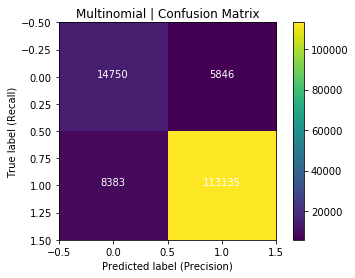

In [44]:
plt.imshow(mnb_cfm, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm.shape[0]), range(mnb_cfm.shape[1])):
    plt.text(j, i, mnb_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | Confusion Matrix')
plt.colorbar();

In [45]:
mnb_f1 = f1_score(y_test, mnb_y_pred)
print("Multinomial NB - F1 score: {:.3f}".format(mnb_f1))

Multinomial NB - F1 score: 0.941


## `TfidfVectorizer`

In [46]:
# Vectorize X_train
mnb_tfidfvectorizer = TfidfVectorizer(min_df=5).fit(x_train)
mnb_X_train = mnb_tfidfvectorizer.transform(x_train)
print("X_train:\n{}".format(repr(mnb_X_train)))

X_train:
<426340x36651 sparse matrix of type '<class 'numpy.float64'>'
	with 22909919 stored elements in Compressed Sparse Row format>


In [47]:
mnb_X_test = mnb_tfidfvectorizer.transform(x_test)

mnb_y_pred = mnb.predict(mnb_X_test)

In [48]:
mnb_score2 = accuracy_score(y_test, mnb_y_pred)
print("Accuracy:   {:.3f}".format(mnb_score2))

Accuracy:   0.884


In [49]:
print("Training set score: {:.3f}".format(mnb.score(mnb_X_train, y_train)))
print("Test set score: {:.3f}".format(mnb.score(mnb_X_test, y_test)))

Training set score: 0.889
Test set score: 0.884


In [50]:
mnb_cfm2 = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm2, end='\n\n')
print('-'*15)
print(np.array([['TN', 'FP'],[ 'FN' , 'TP']]))

Confusion matrix:
[[  4641  15955]
 [   559 120959]]

---------------
[['TN' 'FP']
 ['FN' 'TP']]


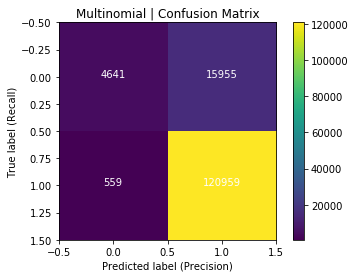

In [51]:
plt.imshow(mnb_cfm2, interpolation='nearest')

for i, j in itertools.product(range(mnb_cfm2.shape[0]), range(mnb_cfm2.shape[1])):
    plt.text(j, i, mnb_cfm2[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Multinomial | Confusion Matrix')
plt.colorbar();

In [52]:
mnb2_f1 = f1_score(y_test, mnb_y_pred)
print("Multinomial NB - F1 score: {:.3f}".format(mnb2_f1))

Multinomial NB - F1 score: 0.936


### Summary:

* Logistic with TF wins!

* Multinomial NB with Tfidf in second.

* Take aways - What could SVM or Random Forest result in? What's going with Logistic Tfidf?

---

# `Clustering / Topic Modeling (NMF and Lda)`

---
## Clustering Vectorize:
### `CountVectorizer` & `Tf-idf`


* With NLTK stopwords 

In [53]:
# Use tf-idf features
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(review_text)

# Use tf features
tf_vectorizer = CountVectorizer(stop_words=stops)
tf = tf_vectorizer.fit_transform(review_text)

In [54]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("Number of total features: {}".format(len(tfidf_feature_names)))

Number of total features: 120107


---
## Build Clustering Models:
## `Nonnegative Matrix Factorization (NMF)` 
### & 
## `Latent Dirichlet Allocation (Lda)`

In [55]:
# Initialize NMF
nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5)

# Initialize Ida
lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [59]:
num_top_words = 15

def retrieve_top_words(model, feature_names, num_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic #{}:".format(idx), end='\n')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]), end='\n\n')
    print()

## `Term frequency` [ tf ]

## NMF

In [56]:
nmf_tf = nmf.fit(tf)

In [57]:
nmf_ = nmf_tf.transform(tf)
Counter([np.argmax(i) for i in nmf_])

Counter({0: 73625,
         1: 129916,
         2: 29354,
         3: 41520,
         4: 40508,
         5: 59624,
         6: 17456,
         7: 72745,
         8: 36418,
         9: 67288})

In [60]:
retrieve_top_words(nmf_tf, tfidf_feature_names, num_top_words)

Topic #0:
br fat sugar ingredients per organic magnesium also protein may natural vitamin calories less oil

Topic #1:
one great would get love flavor time little much use also make even find buy

Topic #2:
food cat cats eat diet chicken eating dry would day ingredients foods feed wellness feeding

Topic #3:
tea green teas flavor drink black bags cup stash bag organic drinking iced love leaves

Topic #4:
coffee cup cups roast strong flavor one pods keurig starbucks blend bold drink pod brew

Topic #5:
product amazon com www http gp href pack ounce price 12 use products order cans

Topic #6:
water drink taste bottle drinking bottled ph essentia coconut use add make alkaline also tap

Topic #7:
like taste flavor really tastes sugar sweet chocolate try much would tried think drink flavors

Topic #8:
dog dogs treats treat food loves get bag give small would one time love chew

Topic #9:
good taste really price pretty flavor better tastes quality sugar healthy snack well chips protein




## Lda

In [61]:
lda_tf = lda.fit(tf)

/home/varuni/anaconda3/envs/mlearn/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


KeyboardInterrupt: 

In [145]:
lda_ = lda_tf.transform(tfut)
Counter([np.argmax(i) for i in lda_])

Counter({0: 113757,
         1: 30429,
         2: 38344,
         3: 38588,
         4: 29083,
         5: 869,
         6: 24005,
         7: 2616,
         8: 10653,
         9: 7993})

In [146]:
retrieve_top_words(lda_tf, tfidf_feature_names, num_top_words)

Topic #0:
use one like well would get great really also time need much keep little good

Topic #1:
bike easy side front mount use tool ride one fit rack back lock screw rear

Topic #2:
like one would plastic good get looks time better much thing watch really first little

Topic #3:
great good price well quality 34 product would made buy recommend works one fit like

Topic #4:
knife blade handle steel sharp one knives sheath like good edge great well pocket use

Topic #5:
light battery bright batteries laser installed green rain power red pedometer lantern computer data charger

Topic #6:
gun scope sight rifle range holster ar shooting pistol rail rounds sights 22 stock use

Topic #7:
bag pack small carry pocket gear pockets phone side camping inside bags velcro fire stuff

Topic #8:
ball one color old set tent minutes got fun back stand kids year 25 34

Topic #9:
water bottle clean use stove cleaning kit bottles hot pot cup lid used cap drink




### ..........<  `Lda / tf Topics`  >..........
    Topic #0:
    use one like well would get great really also time need much keep little good
    
**[ -- Positive Feedback -- ]**

    Topic #1:
    bike easy side front mount use tool ride one fit rack back lock screw rear
    
**[ Biking ]**

    Topic #2:
    like one would plastic good get looks time better much thing watch really first little
    
**[ ??? ]**

    Topic #3:
    great good price well quality 34 product would made buy recommend works one fit like
    
**[ -- Positive Feedback ]**

    Topic #4:
    knife blade handle steel sharp one knives sheath like good edge great well pocket use
    
**[ Knives and accessories ]**

    Topic #5:
    light battery bright batteries laser installed green rain power red pedometer lantern computer data charger
    
**[ Outdoor Electronics ]**

    Topic #6:
    gun scope sight rifle range holster ar shooting pistol rail rounds sights 22 stock use
    
**[ Shooting ]**

    Topic #7:
    bag pack small carry pocket gear pockets phone side camping inside bags velcro fire stuff
    
**[ Backpacking ]**

    Topic #8:
    ball one color old set tent minutes got fun back stand kids year 25 34
    
**[ ??? ]**

    Topic #9:
    water bottle clean use stove cleaning kit bottles hot pot cup lid used cap drink
    
**[ Water bottle/Cooking ]**

## `Term frequency-inverse document frequency` [ tfidf ]

## NMF

In [104]:
nmf_tfidf = nmf.fit(tfidf)

In [105]:
nmf_W = nmf_tfidf.transform(tfidf)
Counter([np.argmax(i) for i in nmf_W])

Counter({0: 109098,
         1: 21925,
         2: 26765,
         3: 22902,
         4: 24061,
         5: 23085,
         6: 11945,
         7: 14761,
         8: 28261,
         9: 13534})

In [106]:
retrieve_top_words(nmf_tfidf, tfidf_feature_names, num_top_words)

Topic #0:
one like use get would time little really much used better need work bought also

Topic #1:
knife blade sharp sheath knives handle edge steel pocket carry hand open clip box edc

Topic #2:
great works product price easy recommend buy love looks use highly work item would install

Topic #3:
scope sight rifle mount dot sights rail 22 red rings gun ar zero range mounted

Topic #4:
bike light bright easy rack road seat ride riding bikes mount lights install tire mountain

Topic #5:
good quality price product buy nice looks pretty would value recommend high seems money job

Topic #6:
34 size fit waist large belt length case barrel medium shorts tactical ordered fits small

Topic #7:
bag pack carry sleeping small bags range room bug pockets straps kit gear stuff strap

Topic #8:
well made fit holster works fits belt nice holds perfectly work seems built gun comfortable

Topic #9:
water bottle bottles drink filter cold cap ice nalgene cage cup drinking clean taste mouth




### ..........<  `NMF / tfidf Topics`  >..........

    Topic #0:
    one like use get would time little really much used better need work bought also
    
**[ -- Positive Feedback -- ]**

    Topic #1:
    knife blade sharp sheath knives handle edge steel pocket carry hand open clip box edc
    
**[ Knives and accessories ]**

    Topic #2:
    great works product price easy recommend buy love looks use highly work item would install
    
**[ -- Positive Feedback -- ]**

    Topic #3:
    scope sight rifle mount dot sights rail 22 red rings gun ar zero range mounted
    
**[ Rifle scopes/mounting ]**

    Topic #4:
    bike light bright easy rack road seat ride riding bikes mount lights install tire mountain
    
**[ Biking ]**

    Topic #5:
    good quality price product buy nice looks pretty would value recommend high seems money job
    
**[ -- Postive Feedback -- ]**

    Topic #6:
    34 size fit waist large belt length case barrel medium shorts tactical ordered fits small
    
**[ Shooting accessories ]**

    Topic #7:
    bag pack carry sleeping small bags range room bug pockets straps kit gear stuff strap
    
**[ Backpacking ]**

    Topic #8:
    well made fit holster works fits belt nice holds perfectly work seems built gun comfortable
    
**[ Pistol holster(s) ]**

    Topic #9:
    water bottle bottles drink filter cold cap ice nalgene cage cup drinking clean taste mouth
    
**[ Water Bottles ( Nalgene ) ]**

## Lda

In [108]:
lda_tfidf = lda.fit(tfidf)

In [109]:
lda_W = lda_tfidf.transform(tfidf)
Counter([np.argmax(i) for i in lda_W])

Counter({0: 295709,
         1: 48,
         2: 48,
         3: 26,
         4: 30,
         5: 232,
         6: 119,
         7: 33,
         8: 46,
         9: 46})

In [110]:
retrieve_top_words(lda_tfidf, tfidf_feature_names, num_top_words)

Topic #0:
great good well one like use would knife get easy price product works light little

Topic #1:
strobe drills lasers darts 556 speedsafe ghost p15 finder p22 prob 1800 kicked th madden

Topic #2:
tomahawk hydro 8221 laserlyte tipton component golfing reloader blah jaw 8220 triathlon mp5 gather romanian

Topic #3:
stud uncle plugged emailed messenger tcp agility mike quickster snakes 62x54r spanner motorists technically trophy

Topic #4:
dpms golfer 8230 readings retaining wireless apps samsung tablet industries callaway tek swords cuff evaluation

Topic #5:
water bottle stove pot bottles filter cup fuel lid canteen coffee hot taste cooking mouth

Topic #6:
levers witness cygolite monkey rcbs pt trx pi ti crossbows 9658 mma headphone silky ons

Topic #7:
nikon carabiner lil tights bdc turrets acog cree blurry freewheel sightmark boresighter leapers prescription rips

Topic #8:
clubs bivy strands froglube insanity http www sr carabiners ref bcm gp sunday stacker organizing

Topic

### ..........<  `Lda / tfidf Topics`  >..........

    Topic #0:
    great good well one like use would knife get easy price product works light little
    
** [ -- Positive Feedback .. Knife? -- ] **

    Topic #1:
    strobe drills lasers darts 556 speedsafe ghost p15 finder p22 prob 1800 kicked th madden
    
** [ Madden (Shoes) ] **

    Topic #2:
    tomahawk hydro 8221 laserlyte tipton component golfing reloader blah jaw 8220 triathlon mp5 gather romanian
    
** [ Tipton (Rifle cleaning kit) ] **

    Topic #3:
    stud uncle plugged emailed messenger tcp agility mike quickster snakes 62x54r spanner motorists technically trophy
    
** [ ??? ] **

    Topic #4:
    dpms golfer 8230 readings retaining wireless apps samsung tablet industries callaway tek swords cuff evaluation
    
** [ Samsumg, tablet, wireless, apps ] **

    Topic #5:
    water bottle stove pot bottles filter cup fuel lid canteen coffee hot taste cooking mouth
    
** [ _Camping_ ] **

    Topic #6:
    levers witness cygolite monkey rcbs pt trx pi ti crossbows 9658 mma headphone silky ons
    
** [ Cygolite (headlamp) ] **

    Topic #7:
    nikon carabiner lil tights bdc turrets acog cree blurry freewheel sightmark boresighter leapers prescription rips
    
** [ Nikon (scopes/cameras) ] **

    Topic #8:
    clubs bivy strands froglube insanity http www sr carabiners ref bcm gp sunday stacker organizing
    
** [ bivy (sleepingbag-tents) ] **

    Topic #9:
    invicta wahoo golfers hoodie buttpad shades pachmayr mako headbands cop baseballs koozie setups void benelli
    
** [ Invicta (watch), Pachmayr (handgun grips), Mako (fishing), Benelli (Rifle) ] **

### Summary:

* Both **NMF and Lda with tf** were about the same and just ok.


* **NMF with tfidf** was the best - with no obsure topics and even correctly associated a topic with a Brand (Nalgene)


* **Lda with tfidf** was primarily a unassociated words
        However - it did return the most specific and unique words out of them all (i.e. brand news)

---
# $$NEXT\ STEPs$$

### Model Tweaking or Fix:
* Effectively handle Imbalance
* Figure out what happened with `TfidfVectorizer` with Pipeline through `GridSearchCV`
* Random Forest:

---
### Random Forest
>### [ `X` ] _tfidf-vectorized reviews_

>### [ `y` ] _Overall scores_

In [ ]:
# Random Forest on tfidf_vectorized (X) ; overall scores (y)

# Accuracy scores
# Confusion matrix
# F1 score

### Further Application/Productization:
* `Recommendation Engine: Collaborative filtering & Factorization Machine`
* Scraping `REI` and/or other sports ecommerce sites in order to build a better, more robust `Recommendation Engine` for Sports and Outdoors products -- to reach the goal of a **Recommendation Engine Chatbot for Sports and Outdoors Products** (for say Facebook or Slack)

#      $$Questions?  $$  